# Airbnb Data

This project looks at Airbnb Listing and Review data in Seattle 

Three questions:
1. What features relate to higher ratings
2. Which time of the year is good for business?
3. How to price appropriately? (predict price by time and features)

Data was scraped on 1/4/2016

Data of bookings (calendar.csv) ranged from 1/4/2016 to 1/2/2017

# Table of Content
1. [Initial data exploration](#heading1)
2. [Prepare data](#heading2)
(Validate data, treat missing values, feature engineer, create dummy variables for modeling)
    1. [Calendar Data set](#heading2.1)
    2. [Listing Data set](#heading2.2)


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

from IPython.display import display

In [71]:
# All information about the rentals and hosts
listings_df = pd.read_csv('./treated_data/listings_df.csv')
listings_df.drop(listings_df.columns[0], axis = 1, inplace = True)

# Contains all columns in listings_df, but categorical vars are made into dummy vars
listings_df_dummy = pd.read_csv('./treated_data/listings_df_dummy.csv')
listings_df_dummy.drop(listings_df_dummy.columns[0], axis = 1,inplace = True)

# similar to listings_df_dummy, just dont have host_response_time & host_response_rate
listings_df_price = pd.read_csv('./treated_data/listings_df_price.csv')
listings_df_price.drop(listings_df_price.columns[0], axis = 1,inplace = True)

# listings_df joined with calendar df
joined_calendar_listings = pd.read_csv('./treated_data/joined_calendar_listings.csv')
joined_calendar_listings.drop(joined_calendar_listings.columns[0], axis = 1,inplace = True)

# same as above, with dummy var
joined_calendar_listings_dummy = pd.read_csv('./treated_data/joined_calendar_listings_dummy.csv')
joined_calendar_listings_dummy.drop(joined_calendar_listings_dummy.columns[0], axis = 1,inplace = True)

In [74]:
listings_df.dtypes

id                             int64
host_id                        int64
host_response_time           float64
host_response_rate           float64
host_is_superhost             object
host_total_listings_count    float64
neighborhood                  object
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
price                        float64
guests_included                int64
extra_people                 float64
availability_30                int64
availability_60                int64
availability_90                int64
availability_365               int64
number_of_reviews              int64
review_scores_rating         float64
cancellation_policy            int64
reviews_per_month            float64
d

In [72]:
# Function: Convert object to date
def to_date(df, col):
    '''
    Input: 
        df: dataframe
        col: column in string format (object) you want to convert into date
    Output:
        df: dataframe with updated column in date format. Every other columns are kept intact
    '''
    df[col] = pd.to_datetime(df[col])
    return df

In [73]:
joined_calendar_listings = to_date(joined_calendar_listings, 'date')
joined_calendar_listings_dummy = to_date(joined_calendar_listings_dummy, 'date')

In [75]:
joined_calendar_listings.dtypes

listing_id                            int64
date                         datetime64[ns]
available                            object
price_calendar                      float64
id                                    int64
host_id                               int64
host_response_time                  float64
host_response_rate                  float64
host_is_superhost                    object
host_total_listings_count           float64
neighborhood                         object
latitude                            float64
longitude                           float64
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
price_y                             float64
guests_included                       int64
extra_people                    

**Note on features of listings_df**

- host_response_time: 'within an hour' = 1,'within a few hours' = 2 ,'within a day' = 3 , 'a few days or more = 4

- cancellation_policy: 'flexible' =1, 'moderate'= 2,'strict'= 3
  
- neighborhood_type: 'High price' = mean price >$100, 'Low price' = mean price <$100

- property_type: house, apartment, other


In [24]:
listings_df.head()

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,neighborhood,latitude,longitude,property_type,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month,days_hosted,neighborhood_type
0,241032,956883,2.0,96.0,f,3.0,Queen Anne,47.636289,-122.371025,Apartment,...,14,41,71,346,207,95.0,2,4.07,1607.0,high price
1,953595,5177328,1.0,98.0,t,6.0,Queen Anne,47.639123,-122.365666,Apartment,...,13,13,16,291,43,96.0,3,1.48,1047.0,high price
2,3308979,16708587,2.0,67.0,f,2.0,Queen Anne,47.629724,-122.369483,House,...,1,6,17,220,20,97.0,3,1.15,571.0,high price
3,7421966,9851441,NaN,NaN,f,1.0,Queen Anne,47.638473,-122.369279,Apartment,...,0,0,0,143,0,0.0,1,0.00,789.0,high price
4,278830,1452570,1.0,100.0,f,2.0,Queen Anne,47.632918,-122.372471,House,...,30,60,90,365,38,92.0,3,0.89,1497.0,high price


In [25]:
# Contains all columns in listings_df, but categorical vars are made into dummy vars
listings_df_dummy.head()

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,neighborhood,latitude,longitude,accommodates,...,neighborhood_type_high price,neighborhood_type_low price,bed_type_Other,bed_type_Real Bed,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,241032,956883,2.0,96.0,f,3.0,Queen Anne,47.636289,-122.371025,4,...,1,0,0,1,1,0,0,1,0,0
1,953595,5177328,1.0,98.0,t,6.0,Queen Anne,47.639123,-122.365666,4,...,1,0,0,1,1,0,0,1,0,0
2,3308979,16708587,2.0,67.0,f,2.0,Queen Anne,47.629724,-122.369483,11,...,1,0,0,1,0,1,0,1,0,0
3,7421966,9851441,NaN,NaN,f,1.0,Queen Anne,47.638473,-122.369279,3,...,1,0,0,1,1,0,0,1,0,0
4,278830,1452570,1.0,100.0,f,2.0,Queen Anne,47.632918,-122.372471,6,...,1,0,0,1,0,1,0,1,0,0


In [27]:
#similar to listings_df_dummy, just dont have host_response_time & host_response_rate
listings_df_price.head()

,id,host_id,host_is_superhost,host_total_listings_count,neighborhood,latitude,longitude,accommodates,bathrooms,bedrooms,...,neighborhood_type_high price,neighborhood_type_low price,bed_type_Other,bed_type_Real Bed,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,241032,956883,f,3.0,Queen Anne,47.636289,-122.371025,4,1.0,1.0,...,1,0,0,1,1,0,0,1,0,0
1,953595,5177328,t,6.0,Queen Anne,47.639123,-122.365666,4,1.0,1.0,...,1,0,0,1,1,0,0,1,0,0
2,3308979,16708587,f,2.0,Queen Anne,47.629724,-122.369483,11,4.5,5.0,...,1,0,0,1,0,1,0,1,0,0
3,7421966,9851441,f,1.0,Queen Anne,47.638473,-122.369279,3,1.0,0.0,...,1,0,0,1,1,0,0,1,0,0
4,278830,1452570,f,2.0,Queen Anne,47.632918,-122.372471,6,2.0,3.0,...,1,0,0,1,0,1,0,1,0,0


In [28]:
# listings_df_price joined with calendar df
joined_calendar_listings.head()

,listing_id,date,available,price_calendar,id,host_id,host_is_superhost,host_total_listings_count,neighborhood,latitude,...,neighborhood_type_high price,neighborhood_type_low price,bed_type_Other,bed_type_Real Bed,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,241032,2016-01-04,t,85.0,241032,956883,f,3.0,Queen Anne,47.636289,...,1,0,0,1,1,0,0,1,0,0
1,241032,2016-01-05,t,85.0,241032,956883,f,3.0,Queen Anne,47.636289,...,1,0,0,1,1,0,0,1,0,0
2,241032,2016-01-13,t,85.0,241032,956883,f,3.0,Queen Anne,47.636289,...,1,0,0,1,1,0,0,1,0,0
3,241032,2016-01-14,t,85.0,241032,956883,f,3.0,Queen Anne,47.636289,...,1,0,0,1,1,0,0,1,0,0
4,241032,2016-01-18,t,85.0,241032,956883,f,3.0,Queen Anne,47.636289,...,1,0,0,1,1,0,0,1,0,0


## Analyze & Visualize

### Continuous Variable

In [30]:
listings_df.drop(columns=['longitude', 'latitude', 'host_id', 'id'], axis =1 ).describe()

,host_response_time,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month,days_hosted
count,3295.000000,3295.000000,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3816.000000
mean,1.690744,94.886798,7.157757,3.349398,1.259469,1.307712,1.735394,127.976166,1.672603,10.667627,16.786276,36.814825,58.082504,244.772656,22.223415,78.518596,2.069932,1.737514,837.273585
std,0.803353,11.866705,28.628149,1.977599,0.590369,0.883395,1.139480,90.250022,1.311040,17.585922,12.173637,23.337541,34.063845,126.772526,37.730892,35.979061,0.817084,1.835425,569.795123
min,1.000000,17.000000,1.000000,1.000000,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,98.000000,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,1.000000,0.000000,2.000000,13.000000,28.000000,124.000000,2.000000,87.000000,1.000000,0.310000,355.000000
50%,1.000000,100.000000,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,1.000000,0.000000,20.000000,46.000000,73.000000,308.000000,9.000000,95.000000,2.000000,1.105000,752.500000
75%,2.000000,100.000000,3.000000,4.000000,1.000000,2.000000,2.000000,150.000000,2.000000,20.000000,30.000000,59.000000,89.000000,360.000000,26.000000,98.000000,3.000000,2.660000,1235.000000
max,4.000000,100.000000,502.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,15.000000,300.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,3.000000,12.150000,2611.000000


All variables are not normally distributed, which we must pay attention to when modelling. Regression might not be a good choice to model data as is. Maybe we can benefit from log-transformed regression.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1185e10b8>,
      dtype=object)

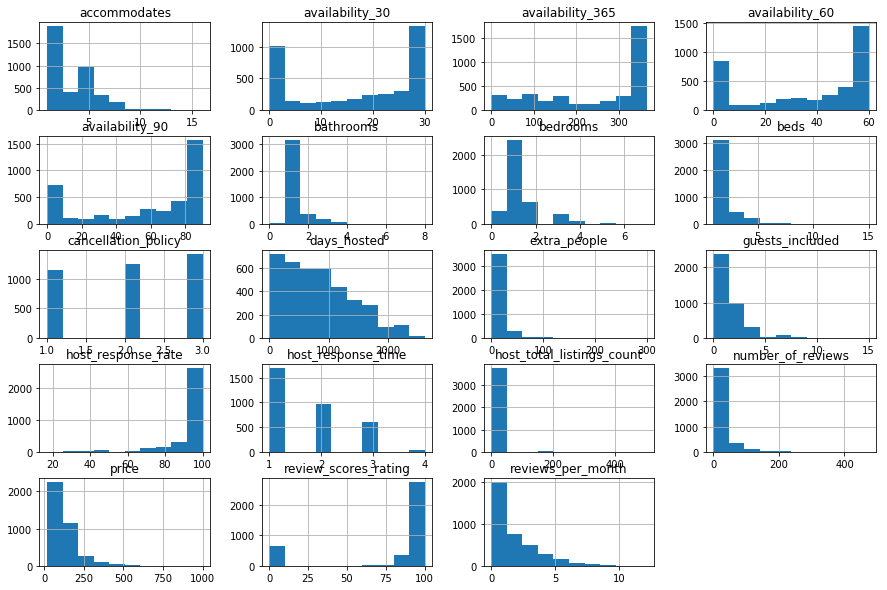

In [29]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
listings_df.drop(columns=['longitude', 'latitude', 'host_id', 'id'], axis =1 ).hist(ax = ax)

Log-transformed price resembles a normal curve. We should use log-transformed Price in regression model instead of just Price

Other variables that give us more information when log-transformed are: 
- days_hosted
- number_of_reviews
- reviews_per_month

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a0d99e8>,
      dtype=object)

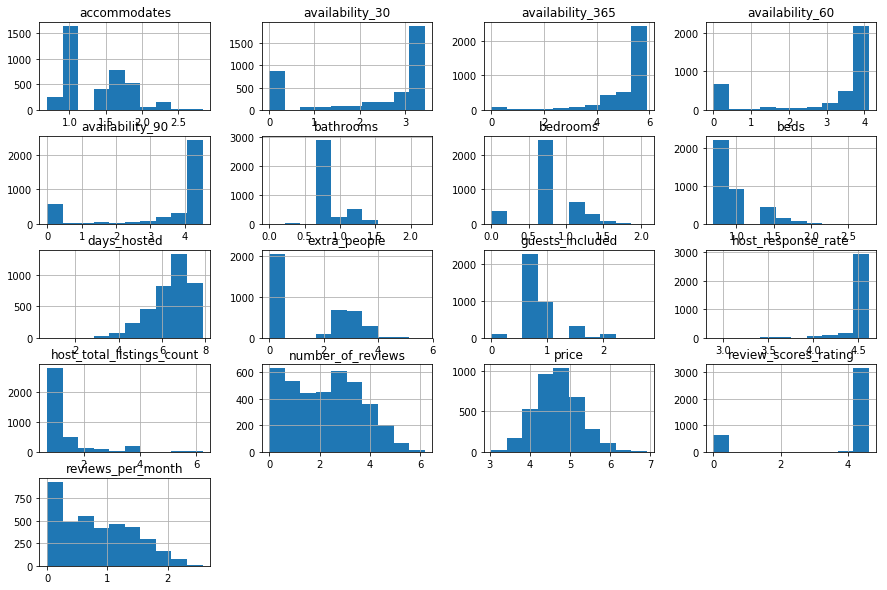

In [31]:
to_log_df = listings_df[['accommodates','availability_30', 'availability_365', 'availability_60', 'availability_90',\
                    'bathrooms', 'bedrooms','beds','days_hosted', 'extra_people','guests_included',\
                    'host_response_rate','host_total_listings_count','number_of_reviews','price',\
                    'review_scores_rating','reviews_per_month']]
log_df = np.log(to_log_df+1)

fig = plt.figure(figsize=(15,10))
ax = fig.gca()
log_df.hist(ax = ax)


#### Correlational Matrix: 

Observations: 
- Hosts take longer time to respond have fewer reviews per month, and have lightly lower score

- Price is positively correlated with number of features (number of people a rental can accommodate, number of beds, bathrooms, and bedrooms). This makes sense but does not help us to learn anything new. However, correlational only reflect linear relationship. Some non-linear relationship might still be hidden.

- Review score has a relatively strong positive relationship with number of reviews per month. Is that people who host more provide generally better services? Or most review are rated high (10 or close to 10), so more reviews means higher score? 

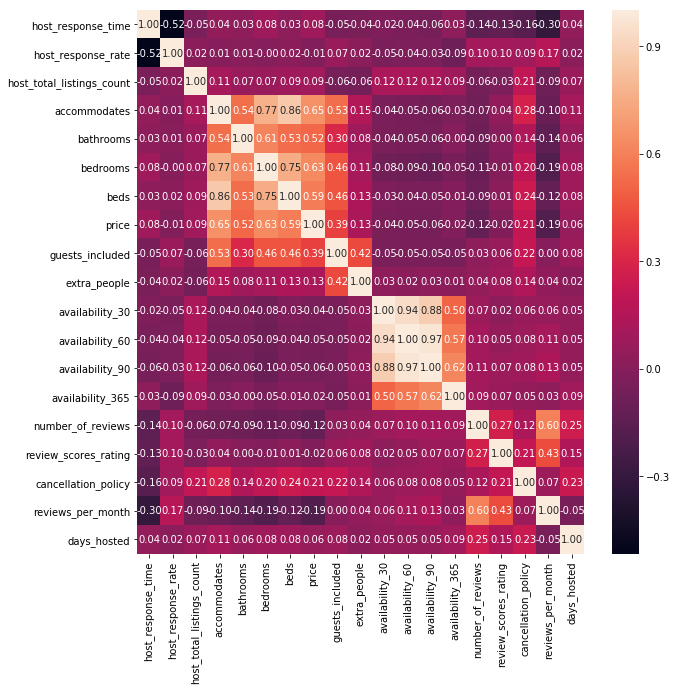

In [32]:
plt.figure(figsize = (10,10))
sns.heatmap(listings_df.drop(columns = ['id', 'host_id', 'latitude', 'longitude']).corr(), annot=True, fmt=".2f")

### Categorical Variables

Text(0.5, 1.0, 'host_is_superhost')

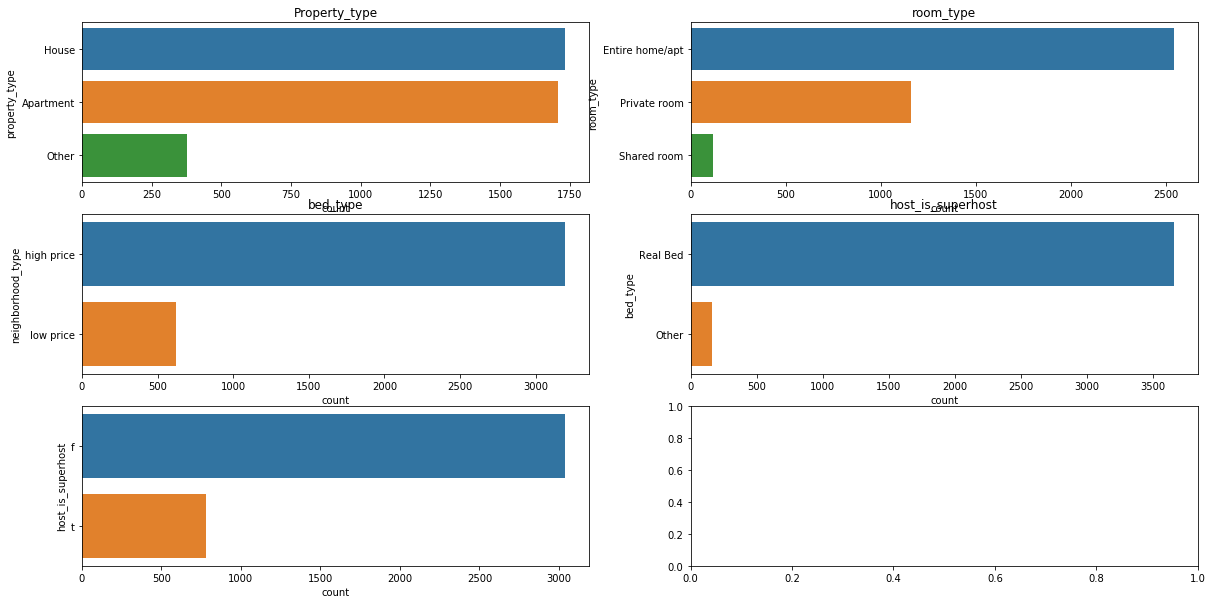

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))

sns.countplot(y='property_type', data =  listings_df,\
              order=listings_df['property_type'].value_counts().index, ax = axs[0][0])
axs[0, 0].set_title('Property_type')

sns.countplot(y='room_type', data =  listings_df,\
              order=listings_df['room_type'].value_counts().index, ax = axs[0][1])
axs[0, 1].set_title('room_type')

sns.countplot(y='neighborhood_type', data =  listings_df,\
              order=listings_df['neighborhood_type'].value_counts().index, ax = axs[1][0])
axs[1, 0].set_title('neighborhood_type')

sns.countplot(y='bed_type', data =  listings_df,\
              order=listings_df['bed_type'].value_counts().index, ax = axs[1][1])
axs[1, 0].set_title('bed_type')

sns.countplot(y='host_is_superhost', data =  listings_df,\
              order=listings_df['host_is_superhost'].value_counts().index, ax = axs[2][0])
axs[1, 1].set_title('host_is_superhost')


### Multivariate analysis - Price 

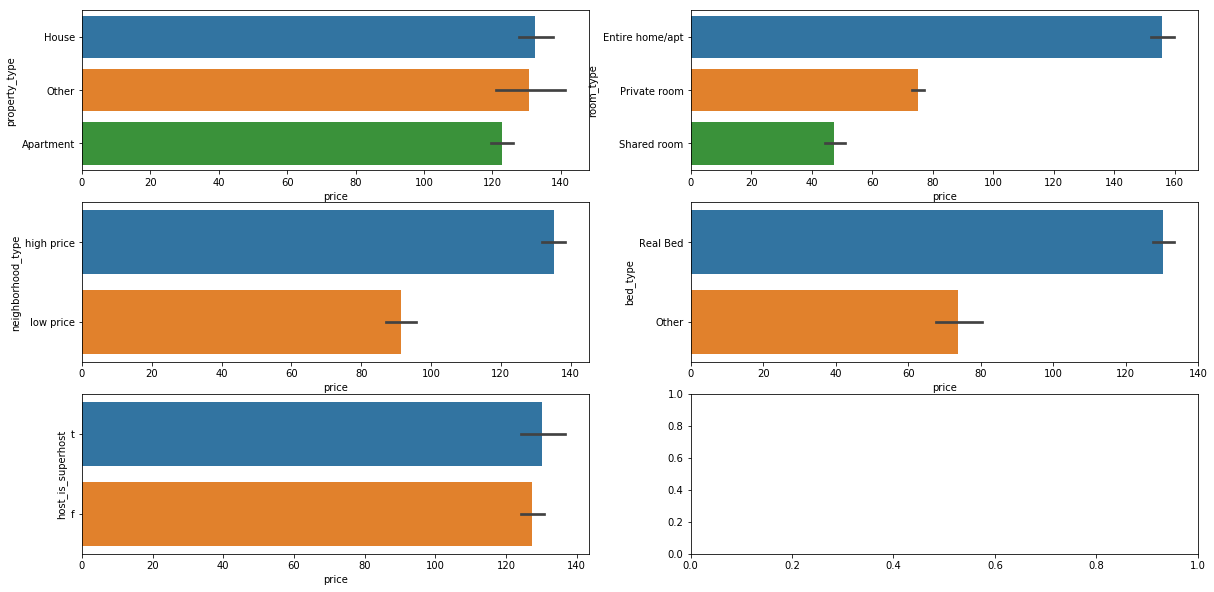

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))

sns.barplot(y = 'property_type', x = 'price', data =  listings_df, \
            order=listings_df.groupby('property_type')['price'].mean().sort_values(ascending=False).index,\
            ax = axs[0,0])


sns.barplot(y = 'room_type', x = 'price', data =  listings_df, ax = axs[0,1])


sns.barplot(y = 'neighborhood_type', x = 'price', data =  listings_df, 
            order=listings_df.groupby('neighborhood_type')['price'].mean().sort_values(ascending=False).index,\
            ax = axs[1,0])


sns.barplot(y = 'bed_type', x = 'price', data =  listings_df, 
            order=listings_df.groupby('bed_type')['price'].mean().sort_values(ascending=False).index,\
            ax = axs[1,1])


sns.barplot(y = 'host_is_superhost', x = 'price', data =  listings_df,\
            order=listings_df.groupby('host_is_superhost')['price'].mean().sort_values(ascending=False).index,\
            ax = axs[2,0])


### Multivariate analysis - Time & Price 

Observation about temporal pattern of price:

- Apartment price rises in summer months (possibly group Jun, Jul, Aug into a group, or group by quarter?)
- Entire house/apartment price also rises slightly in summer months
- High priced neighborhood seems to have higher price flutuation throughout the year

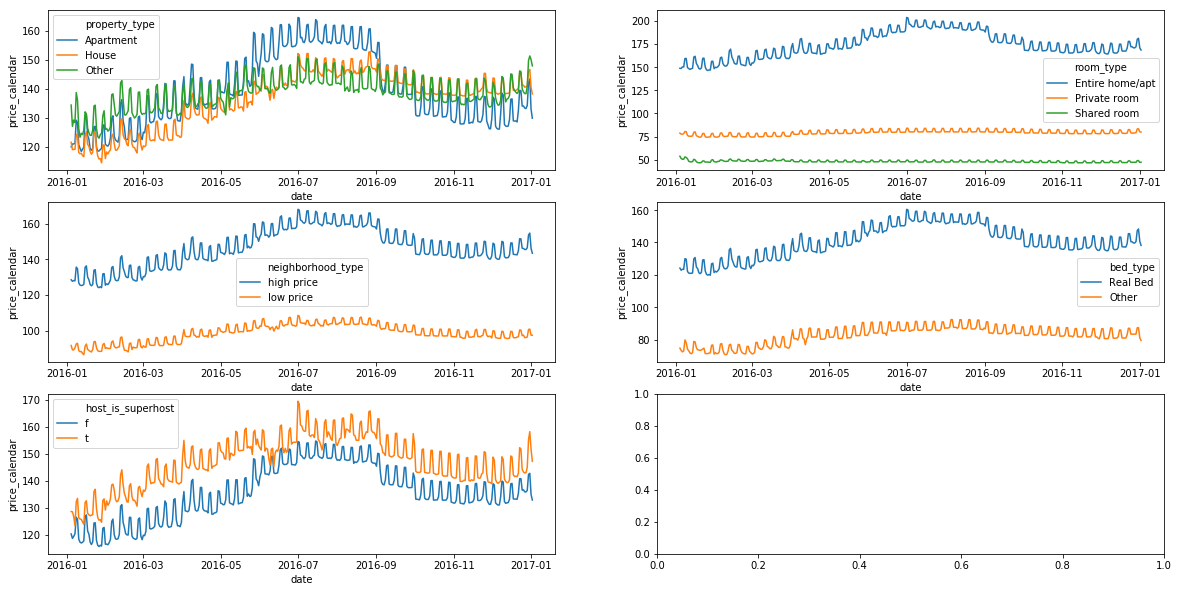

In [76]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))

sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'property_type', ci = None, ax = axs[0,0])
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'room_type', ci = None, ax = axs[0,1])
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'neighborhood_type', ci = None, ax = axs[1,0])
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'bed_type', ci = None, ax = axs[1,1])
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'host_is_superhost', ci = None, ax = axs[2,0])

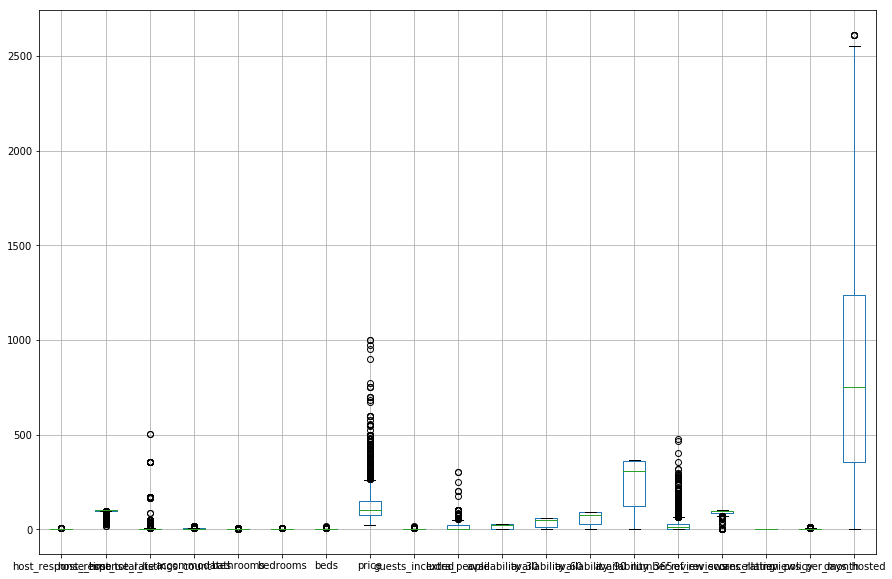

In [48]:
fig = plt.figure(figsize=(15,10))
listings_df.drop(columns=['longitude', 'latitude', 'host_id', 'id'], axis =1 ).boxplot()

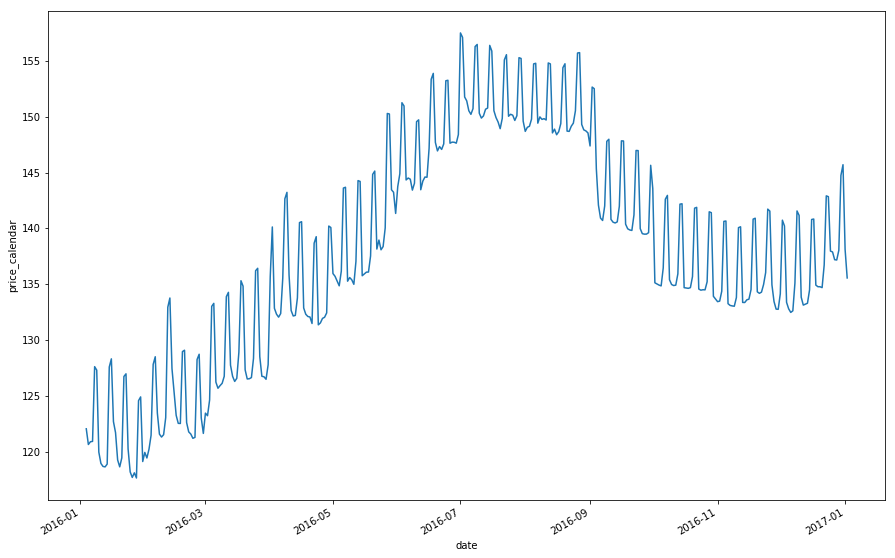

In [77]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
 ci = None)
fig.autofmt_xdate()

In [80]:
temp = joined_calendar_listings[['date','price_y', 'price_calendar']]
temp['% change'] = (temp['price_calendar'] - temp['price_y'])/temp['price_y']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
temp.describe()

,price_y,price_calendar,% change
count,934542.000000,934542.000000,934542.000000
mean,127.249518,137.944859,0.083801
std,90.602147,105.062870,0.290062
min,20.000000,10.000000,-0.940828
25%,75.000000,75.000000,0.000000
50%,100.000000,109.000000,0.000000
75%,150.000000,160.000000,0.000000
max,1000.000000,1650.000000,7.378378


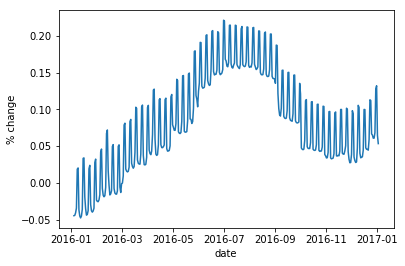

In [82]:
sns.lineplot(data = temp, x = 'date', y = '% change', \
 ci = None)

In [70]:
chart_data.dtypes

date         object
% change    float64
dtype: object